### Libraries


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import librosa
import os
import matplotlib.pyplot as plt
from itertools import islice
from sklearn.metrics import r2_score
import pickle
from sklearn.metrics import mean_squared_error

# import parselmouth
from scipy.signal import lfilter, lfilter_zi

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

### CSV File readings


In [14]:
# Define a function to map the age ranges to integer values
def map_age_range(age):
    if age == "teens":
        return random.randint(13, 19)
    elif age == "twenties":
        return random.randint(20, 29)
    elif age == "thirties":
        return random.randint(30, 39)
    elif age == "fourties":
        return random.randint(40, 49)
    elif age == "fifties":
        return random.randint(50, 59)
    elif age == "sixties":
        return random.randint(60, 69)
    elif age == "seventies":
        return random.randint(70, 79)
    elif age == "eighties":
        return random.randint(80, 89)
    elif age == "nineties":
        return random.randint(90, 99)
    else:
        return 0

In [15]:
# Read the CSV file
df = pd.read_csv("Dataset\cv-valid-test.csv")

# Keep only the filename and age columns
df = df[["filename", "age"]]
df.dropna(subset=["age"], inplace=True)

# Print the resulting dataframe
print(df)


# Replace the age categories with integer values
df["age"] = df["age"].apply(map_age_range)

# Print the resulting dataframe
print(df)


df.to_csv("Dataset/results.csv", index=False)

                             filename       age
1     cv-valid-test/sample-000001.mp3  twenties
3     cv-valid-test/sample-000003.mp3  twenties
5     cv-valid-test/sample-000005.mp3  twenties
6     cv-valid-test/sample-000006.mp3  twenties
7     cv-valid-test/sample-000007.mp3  thirties
...                               ...       ...
3976  cv-valid-test/sample-003976.mp3  thirties
3979  cv-valid-test/sample-003979.mp3  thirties
3980  cv-valid-test/sample-003980.mp3   fifties
3984  cv-valid-test/sample-003984.mp3  thirties
3989  cv-valid-test/sample-003989.mp3   fifties

[1542 rows x 2 columns]
                             filename  age
1     cv-valid-test/sample-000001.mp3   25
3     cv-valid-test/sample-000003.mp3   20
5     cv-valid-test/sample-000005.mp3   26
6     cv-valid-test/sample-000006.mp3   26
7     cv-valid-test/sample-000007.mp3   37
...                               ...  ...
3976  cv-valid-test/sample-003976.mp3   30
3979  cv-valid-test/sample-003979.mp3   39
3980  cv-val

In [16]:
# Read the CSV file
df = pd.read_csv("Dataset/truncated_train.csv")

# Keep only the filename and age columns
df = df[["filename", "age"]]
df.dropna(subset=["age"], inplace=True)

# Print the resulting dataframe
print(df)

# Replace the age categories with integer values
df["age"] = df["age"].apply(map_age_range)

# Print the resulting dataframe
print(df)


df.to_csv("Dataset/training_set.csv", index=False)

                               filename        age
5      cv-valid-train/sample-000005.mp3   twenties
8      cv-valid-train/sample-000008.mp3  seventies
13     cv-valid-train/sample-000013.mp3   thirties
14     cv-valid-train/sample-000014.mp3    sixties
19     cv-valid-train/sample-000019.mp3    fifties
...                                 ...        ...
14993  cv-valid-train/sample-014993.mp3   fourties
14994  cv-valid-train/sample-014994.mp3   thirties
14995  cv-valid-train/sample-014995.mp3   thirties
14998  cv-valid-train/sample-014998.mp3   fourties
15000  cv-valid-train/sample-015000.mp3   twenties

[5615 rows x 2 columns]
                               filename  age
5      cv-valid-train/sample-000005.mp3   21
8      cv-valid-train/sample-000008.mp3   76
13     cv-valid-train/sample-000013.mp3   35
14     cv-valid-train/sample-000014.mp3   60
19     cv-valid-train/sample-000019.mp3   54
...                                 ...  ...
14993  cv-valid-train/sample-014993.mp3   48
149

### Feature Extraction


In [17]:
import librosa


def extract_features(filename):
    y, sr = librosa.load(filename)

    # Extract pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches)

    spectrum = np.abs(librosa.stft(y))
    formants = np.mean(librosa.feature.spectral_centroid(S=spectrum))

    # Extract intensity
    intensity = np.mean(librosa.feature.rms(y=y))

    # Extract duration
    duration = librosa.get_duration(y=y, sr=sr)

    # Extract spectral features (example)
    spectral_features = np.mean(librosa.feature.mfcc(y=y, sr=sr))

    # Create a list of features
    features = [pitch, formants, intensity, duration, spectral_features]

    return features

In [18]:
# Read the CSV file
df = pd.read_csv("Dataset/training_set.csv")

# Print the resulting dataframe
print(df)

# Create an empty list to store the features
features_list = []

# Iterate over the first 10 filenames in the DataFrame
# for filename in islice(df['filename'], 10):
for filename in df["filename"]:
    # Construct the full file path
    file_path = "Dataset/" + filename

    # Extract the features for the current file
    features = extract_features(file_path)

    # Append the features to the list
    features_list.append(features)

# Convert the list of features to a DataFrame
features_df = pd.DataFrame(features_list)

# Print the resulting DataFrame
print(features_df)

# Save features as a CSV file
# Read the training set CSV file
training_set = pd.read_csv("Dataset/training_set.csv")

# Add the features to the training set DataFrame
training_set["pitch"] = features_df[0]
training_set["formant_frequency"] = features_df[1]
training_set["intensity"] = features_df[2]
training_set["duration"] = features_df[3]
training_set["spectral_features"] = features_df[4]

# Save the updated training set DataFrame to a new CSV file
training_set.to_csv("Dataset/training_set_with_features.csv", index=False)

                              filename  age
0     cv-valid-train/sample-000005.mp3   21
1     cv-valid-train/sample-000008.mp3   76
2     cv-valid-train/sample-000013.mp3   35
3     cv-valid-train/sample-000014.mp3   60
4     cv-valid-train/sample-000019.mp3   54
...                                ...  ...
5610  cv-valid-train/sample-014993.mp3   48
5611  cv-valid-train/sample-014994.mp3   37
5612  cv-valid-train/sample-014995.mp3   32
5613  cv-valid-train/sample-014998.mp3   47
5614  cv-valid-train/sample-015000.mp3   29

[5615 rows x 2 columns]
              0            1         2         3          4
0     15.154385  1827.311994  0.006928  5.832018 -27.616850
1     45.197166  2405.960497  0.015059  1.728027 -21.074587
2     34.405575  1853.162931  0.038097  4.224036 -20.890915
3      6.007706  1844.103885  0.032311  5.376009 -17.845568
4     10.936522  1910.189138  0.045045  3.720000  -3.291732
...         ...          ...       ...       ...        ...
5610  12.031152  2491.09154

### Graph Plotting


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


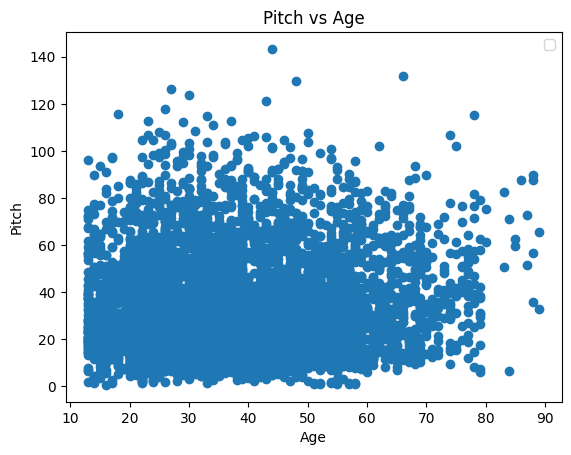

In [19]:
features_df = pd.read_csv("Dataset/training_set_with_features.csv")

# Set the labels and title
plt.scatter(features_df["age"], features_df["pitch"])
plt.xlabel("Age")
plt.ylabel("Pitch")
plt.title("Pitch vs Age")

# Add a legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


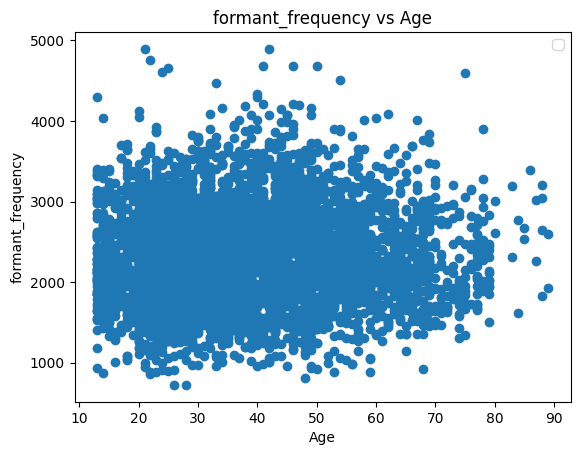

In [20]:
# Set the labels and title
plt.scatter(features_df["age"], features_df["formant_frequency"])
plt.xlabel("Age")
plt.ylabel("formant_frequency")
plt.title("formant_frequency vs Age")

# Add a legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


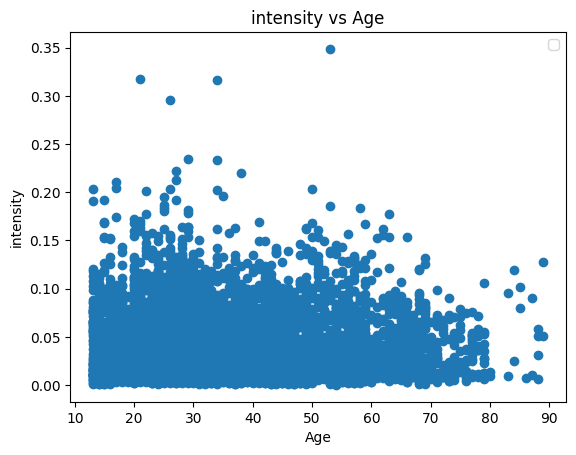

In [21]:
# Set the labels and title
plt.scatter(features_df["age"], features_df["intensity"])
plt.xlabel("Age")
plt.ylabel("intensity")
plt.title("intensity vs Age")

# Add a legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


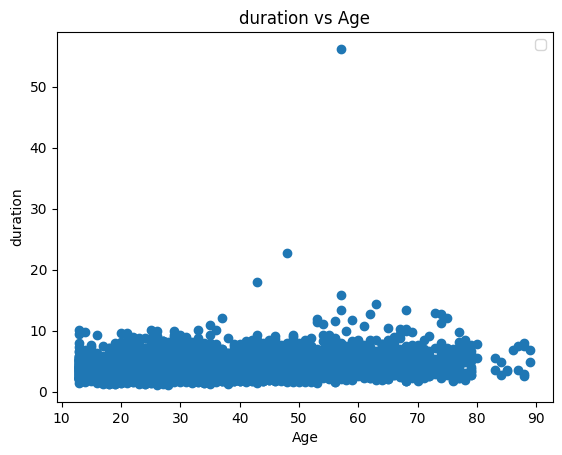

In [22]:
# Set the labels and title
plt.scatter(features_df["age"], features_df["duration"])
plt.xlabel("Age")
plt.ylabel("duration")
plt.title("duration vs Age")

# Add a legend
plt.legend()

# Show the plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


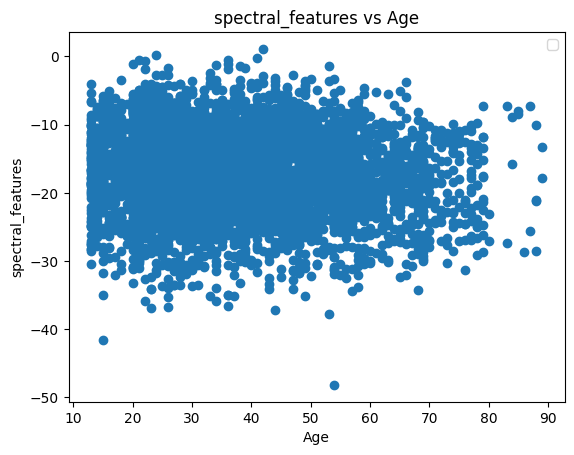

In [23]:
# Set the labels and title
plt.scatter(features_df["age"], features_df["spectral_features"])
plt.xlabel("Age")
plt.ylabel("spectral_features")
plt.title("spectral_features vs Age")

# Add a legend
plt.legend()

# Show the plot
plt.show()

### regression model


In [44]:
features_df = pd.read_csv("Dataset/training_set_with_features.csv")


class LinearRegressions:
    def __init__(
        self,
        learning_rate=0.01,
        n_iterations=1000,
        regularization=None,
        reg_strength=0.1,
    ):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.reg_strength = reg_strength
        self.weights = None
        self.bias = None

    def _normalize_features(self, X):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
        X_normalized = (X - mean) / std
        return X_normalized

    def _compute_cost(self, X, y):
        n_samples = len(y)
        y_pred = np.dot(X, self.weights) + self.bias
        mse = (1 / (2 * n_samples)) * np.sum((y_pred - y) ** 2)

        if self.regularization == "l2":
            reg_term = (self.reg_strength / (2 * n_samples)) * np.sum(self.weights**2)
            mse += reg_term
        elif self.regularization == "l1":
            reg_term = (self.reg_strength / n_samples) * np.sum(np.abs(self.weights))
            mse += reg_term

        return mse

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Normalize features
        X_normalized = self._normalize_features(X)

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient descent
        for _ in range(self.n_iterations):
            # Predictions
            y_pred = np.dot(X_normalized, self.weights) + self.bias

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X_normalized.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        X_normalized = self._normalize_features(X)
        return np.dot(X_normalized, self.weights) + self.bias


column_names = features_df.columns.tolist()
column_names.remove("filename")
column_names.remove("age")
print(column_names)

# Train the model
lr = LinearRegressions(learning_rate=0.01, n_iterations=1000)
lr.fit(features_df[column_names], features_df["age"])

# Make predictions
predictions = lr.predict(features_df[column_names])

print(predictions)

['pitch', 'formant_frequency', 'intensity', 'duration', 'spectral_features']
[40.81434435 35.31246087 37.89215426 ... 34.60155378 36.49656146
 36.77448843]


#### Built in used for checking how close the custom is


In [25]:
features_df = pd.read_csv("Dataset/training_set_with_features.csv")

column_names = features_df.columns.tolist()
column_names.remove("filename")
column_names.remove("age")
print(column_names)
# Create an instance of the RandomForestRegressor model
model = svr_model = SVR(
    kernel="poly"
)  # You can adjust the kernel parameter ('rbf', 'linear', 'poly', etc.)

# Fit the model to the training data
model.fit(features_df[column_names], features_df["age"])

# Predict the age using the trained model
predictions = model.predict(features_df[column_names])

# Print the predicted ages
print(predictions)

['pitch', 'formant_frequency', 'intensity', 'duration', 'spectral_features']
[33.02630217 34.12561575 33.08492549 ... 32.79071895 35.12882861
 33.8178042 ]


### Accuracy and mean


In [36]:
def accuracy(y_true, y_pred):
    """
    Calculate the R-squared accuracy score for regression.

    Parameters:
    - y_true: array-like, true target values
    - y_pred: array-like, predicted target values

    Returns:
    - accuracy: float, R-squared score
    """
    return r2_score(y_true, y_pred)

In [46]:
accuracy(features_df["age"], predictions)
# from sklearn.metrics import accuracy_score

# accuracy2 = accuracy_score(features_df["age"], predictions)
# print(accuracy2)

0.0380690281489342

In [38]:
# Calculate the mean squared error
mse = mean_squared_error(features_df["age"], predictions)

# Print the mean squared error
print("Mean Squared Error:", mse)

Mean Squared Error: 219.37384473333057


In [39]:
# Save the model to a file
with open("model.pkl", "wb") as file:
    pickle.dump(lr, file)

### Final


In [33]:
# Read the results.csv file
results_df = pd.read_csv("Dataset/results.csv")

# Extract the features for each file in results_df
features_list = []
for filename in results_df["filename"]:
    file_path = "Dataset/" + filename
    features = extract_features(file_path)
    features_list.append(features)

# Convert the list of features to a DataFrame
features_df = pd.DataFrame(features_list)

# Print the resulting DataFrame
print(features_df)

# Add the features to the training set DataFrame
results_df["pitch"] = features_df[0]
results_df["formant_frequency"] = features_df[1]
results_df["intensity"] = features_df[2]
results_df["duration"] = features_df[3]
results_df["spectral_features"] = features_df[4]

# Save the updated training set DataFrame to a new CSV file
results_df.to_csv("Dataset/result_set_with_features.csv", index=False)

              0            1         2         3          4
0     41.128212  1955.858160  0.039991  1.944036 -14.599541
1     17.719046  2308.464665  0.009894  7.704036 -24.553049
2     16.266485  1966.360052  0.045127  4.656009 -13.521242
3     81.232689  2991.734249  0.005734  4.680000 -21.191109
4     43.807964  2628.525092  0.031965  2.616009 -10.293879
...         ...          ...       ...       ...        ...
1537  26.840361  1831.163581  0.053497  1.824036 -12.330978
1538  63.121037  2743.037921  0.002047  2.064036 -29.376358
1539   9.939067  1627.018451  0.024364  2.784036  -8.099827
1540   9.941351  1666.764603  0.084790  3.744036  -7.817851
1541  28.120111  2338.355149  0.026282  2.640000  -8.798942

[1542 rows x 5 columns]


In [40]:
results_df = pd.read_csv("Dataset/result_set_with_features.csv")

column_names = results_df.columns.tolist()
column_names.remove("filename")
column_names.remove("age")
print(column_names)

# Load the trained model from the model.pkl file
with open("model.pkl", "rb") as file:
    model = pickle.load(file)

age = results_df["age"]
results_df = results_df.drop(columns=["filename", "age"])
print(results_df.columns.tolist())

# Use the loaded model for predictions or other operations
predictions = model.predict(results_df)

# # Make predictions using the trained model
# predictions = model.predict(features_df[column_names])

# Add the predicted age to the results DataFrame
results_df["predicted_age"] = predictions
results_df["age"] = age

# Display the results DataFrame
print(results_df)
print("Accuracy:", accuracy(results_df["age"], results_df["predicted_age"]))
print("Mean Squared Error:", mean_squared_error(results_df["age"], predictions))

['pitch', 'formant_frequency', 'intensity', 'duration', 'spectral_features']
['pitch', 'formant_frequency', 'intensity', 'duration', 'spectral_features']
          pitch  formant_frequency  intensity  duration  spectral_features  \
0     41.128212        1955.858160   0.039991  1.944036         -14.599541   
1     17.719046        2308.464665   0.009894  7.704036         -24.553050   
2     16.266485        1966.360052   0.045127  4.656009         -13.521242   
3     81.232690        2991.734249   0.005734  4.680000         -21.191109   
4     43.807964        2628.525092   0.031965  2.616009         -10.293879   
...         ...                ...        ...       ...                ...   
1537  26.840360        1831.163581   0.053497  1.824036         -12.330978   
1538  63.121037        2743.037921   0.002047  2.064036         -29.376358   
1539   9.939067        1627.018451   0.024364  2.784036          -8.099827   
1540   9.941351        1666.764603   0.084790  3.744036          -